In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import NaiveSeasonal,NaiveDrift,TFTModel,NBEATSModel, TCNModel,ExponentialSmoothing,Prophet
from darts.metrics import mape, rmse, r2_score,mape
from darts.utils.statistics import check_seasonality, plot_acf,extract_trend_and_seasonality
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.utils import ModelMode, SeasonalityMode, TrendMode

from darts.datasets import SunspotsDataset, AirPassengersDataset

import sys
import time
import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)

2022-04-23 09:52:45 prophet.plot ERROR: Importing plotly failed. Interactive plots will not work.


In [3]:
df = pd.read_csv("C:\\Users\\bduser\\Desktop\\Harsh_Thesis_work\\tsdf.csv")

df.drop(['Unnamed: 0'],axis=1,inplace=True)

df['Price'] = df['Price'].str.replace(',','')
df['Price'] = df['Price'].astype('float')

df['Open'] = df['Open'].str.replace(',','')
df['Open'] = df['Open'].astype('float')

df['High'] = df['High'].str.replace(',','')
df['High'] = df['High'].astype('float')

df['Low'] = df['Low'].str.replace(',','')
df['Low'] = df['Low'].astype('float')


df['Vol.'] = df['Vol.'].astype(str)
for i in range(len(df['Vol.'])):
    if "K" in df['Vol.'][i]:
        df['Vol.'][i] = df['Vol.'][i].replace("K","")
        df['Vol.'][i] = float(df['Vol.'][i])
        df['Vol.'][i] =df['Vol.'][i]*1000

    elif "M" in df['Vol.'][i]:
        df['Vol.'][i] = df['Vol.'][i].replace("M","")
        df['Vol.'][i] = float(df['Vol.'][i])
        df['Vol.'][i] = df['Vol.'][i]*1000000

df['Vol.'] = df['Vol.'].astype(float)

df["Change %"] = df["Change %"].astype(str)
for i in range(len(df["Change %"])):
        df["Change %"][i] = df["Change %"][i].replace("%","")
df["Change %"] = df["Change %"].astype(float)

df['Date'] = pd.to_datetime(df['Date'])

df.set_index("Date",inplace=True)

df.sort_values(by='Date',inplace=True)

In [4]:
df

,Price,Open,High,Low,Vol.,Change %,sentiment_scores,total_tweets,bitcoin: (Worldwide)
Date,,,,,,,,,
2018-01-01,13444.9,13850.5,13921.5,12877.7,78430.0,-2.93,0.065505,62044.0,44
2018-01-02,14754.1,13444.9,15306.1,12934.2,137730.0,9.74,0.055192,77723.0,54
2018-01-03,15156.6,14754.1,15435.0,14579.7,106540.0,2.73,0.043841,79086.0,55
2018-01-04,15180.1,15156.5,15408.7,14244.7,110970.0,0.15,0.056670,74534.0,51
2018-01-05,16954.8,15180.1,17126.9,14832.4,141960.0,11.69,0.048044,76404.0,50
...,...,...,...,...,...,...,...,...,...
2019-11-19,8145.7,8207.7,8245.6,8032.8,654270.0,-0.76,0.140930,16874.0,21
2019-11-20,8099.3,8145.7,8223.0,8074.2,607270.0,-0.57,0.155557,18338.0,19
2019-11-21,7627.9,8099.4,8129.6,7519.7,891500.0,-5.82,0.133958,21597.0,24


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 692 entries, 2018-01-01 to 2019-11-23
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Price                 692 non-null    float64
 1   Open                  692 non-null    float64
 2   High                  692 non-null    float64
 3   Low                   692 non-null    float64
 4   Vol.                  692 non-null    float64
 5   Change %              692 non-null    float64
 6   sentiment_scores      692 non-null    float64
 7   total_tweets          692 non-null    float64
 8   bitcoin: (Worldwide)  692 non-null    int64  
dtypes: float64(8), int64(1)
memory usage: 54.1 KB


In [6]:
df.isnull().sum()

Price                   0
Open                    0
High                    0
Low                     0
Vol.                    0
Change %                0
sentiment_scores        0
total_tweets            0
bitcoin: (Worldwide)    0
dtype: int64

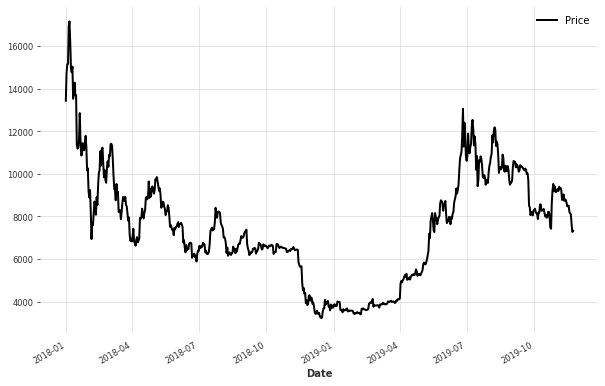

In [7]:
# create time series object for target variable
plt.figure(figsize=(10,6))
series = TimeSeries.from_series(df["Price"]) 
series.plot()

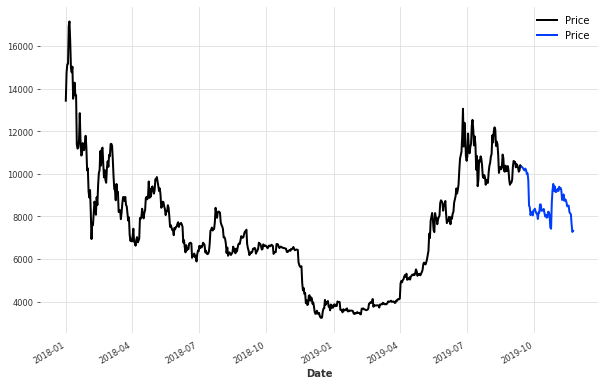

In [8]:
plt.figure(figsize=(10,6))
train, test = series.split_before(0.80)
train.plot()
test.plot()

# Data Preprocessing

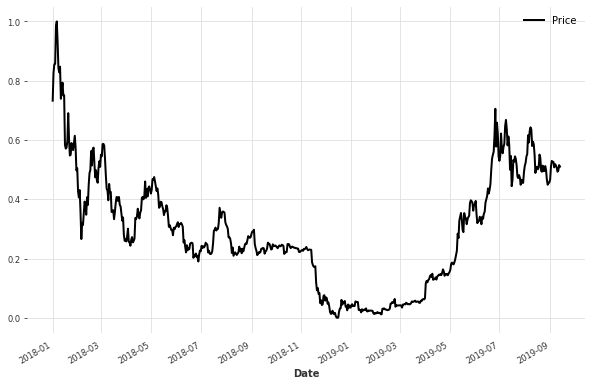

In [9]:
plt.figure(figsize=(10,6))
scaler = Scaler()
train_scaled = scaler.fit_transform(train)

train_scaled.plot()

In [10]:
df2 = df.copy()

df2 = df2.reset_index()

In [11]:
df2.head()

,Date,Price,Open,High,Low,Vol.,Change %,sentiment_scores,total_tweets,bitcoin: (Worldwide)
0,2018-01-01,13444.9,13850.5,13921.5,12877.7,78430.0,-2.93,0.065505,62044.0,44
1,2018-01-02,14754.1,13444.9,15306.1,12934.2,137730.0,9.74,0.055192,77723.0,54
2,2018-01-03,15156.6,14754.1,15435.0,14579.7,106540.0,2.73,0.043841,79086.0,55
3,2018-01-04,15180.1,15156.5,15408.7,14244.7,110970.0,0.15,0.056670,74534.0,51
4,2018-01-05,16954.8,15180.1,17126.9,14832.4,141960.0,11.69,0.048044,76404.0,50


In [12]:
df2.corr()

,Price,Open,High,Low,Vol.,Change %,sentiment_scores,total_tweets,bitcoin: (Worldwide)
Price,1.000000,0.990546,0.995591,0.995343,-0.181196,0.047746,0.395984,0.390213,-0.033927
Open,0.990546,1.000000,0.995849,0.992524,-0.186286,-0.081949,0.389082,0.392496,-0.030248
High,0.995591,0.995849,1.000000,0.991414,-0.183795,-0.016650,0.386749,0.409982,-0.006290
Low,0.995343,0.992524,0.991414,1.000000,-0.185700,-0.002186,0.405666,0.361429,-0.071294
Vol.,-0.181196,-0.186286,-0.183795,-0.185700,1.000000,0.074108,-0.068507,-0.124384,0.234176
Change %,0.047746,-0.081949,-0.016650,-0.002186,0.074108,1.000000,0.062549,-0.009471,-0.013928
sentiment_scores,0.395984,0.389082,0.386749,0.405666,-0.068507,0.062549,1.000000,-0.333542,-0.046422
total_tweets,0.390213,0.392496,0.409982,0.361429,-0.124384,-0.009471,-0.333542,1.000000,0.086123
bitcoin: (Worldwide),-0.033927,-0.030248,-0.006290,-0.071294,0.234176,-0.013928,-0.046422,0.086123,1.000000


In [13]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 692 entries, 0 to 691
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Date                  692 non-null    datetime64[ns]
 1   Price                 692 non-null    float64       
 2   Open                  692 non-null    float64       
 3   High                  692 non-null    float64       
 4   Low                   692 non-null    float64       
 5   Vol.                  692 non-null    float64       
 6   Change %              692 non-null    float64       
 7   sentiment_scores      692 non-null    float64       
 8   total_tweets          692 non-null    float64       
 9   bitcoin: (Worldwide)  692 non-null    int64         
dtypes: datetime64[ns](1), float64(8), int64(1)
memory usage: 54.2 KB


In [14]:
df2 = df2[['Date','Vol.','sentiment_scores','total_tweets','bitcoin: (Worldwide)']]
df2.set_index("Date",inplace=True)

In [15]:
df2

,Vol.,sentiment_scores,total_tweets,bitcoin: (Worldwide)
Date,,,,
2018-01-01,78430.0,0.065505,62044.0,44
2018-01-02,137730.0,0.055192,77723.0,54
2018-01-03,106540.0,0.043841,79086.0,55
2018-01-04,110970.0,0.056670,74534.0,51
2018-01-05,141960.0,0.048044,76404.0,50
...,...,...,...,...
2019-11-19,654270.0,0.140930,16874.0,21
2019-11-20,607270.0,0.155557,18338.0,19
2019-11-21,891500.0,0.133958,21597.0,24


In [16]:
# create time series object for target variable
ts_P = TimeSeries.from_series(df["Price"]) 

# check attributes of the time series
print("components:", ts_P.components)
print("duration:",ts_P.duration)
print("frequency:",ts_P.freq)
print("frequency:",ts_P.freq_str)
print("has date time index? (or else, it must have an integer index):",ts_P.has_datetime_index)
print("deterministic:",ts_P.is_deterministic)
print("univariate:",ts_P.is_univariate)

components: Index(['Price'], dtype='object', name='component')
duration: 691 days 00:00:00
frequency: <Day>
frequency: D
has date time index? (or else, it must have an integer index): True
deterministic: True
univariate: True


In [17]:
#df2.drop(['Price'],axis=1,inplace=True)
ts_covF = TimeSeries.from_dataframe(df2)

# check attributes of the time series
print("components (columns) of feature time series:", ts_covF.components)
print("duration:",ts_covF.duration)
print("frequency:",ts_covF.freq)
print("frequency:",ts_covF.freq_str)
print("has date time index? (or else, it must have an integer index):",ts_covF.has_datetime_index)
print("deterministic:",ts_covF.is_deterministic)
print("univariate:",ts_covF.is_univariate)

components (columns) of feature time series: Index(['Vol.', 'sentiment_scores', 'total_tweets', 'bitcoin: (Worldwide)'], dtype='object', name='component')
duration: 691 days 00:00:00
frequency: <Day>
frequency: D
has date time index? (or else, it must have an integer index): True
deterministic: True
univariate: False


In [18]:
# example: operating with time series objects:
# we can also create a 3-dimensional numpy array from a time series object
# 3 dimensions: time (rows) / components (columns) / samples
ar_covF = ts_covF.all_values()
print(type(ar_covF))
ar_covF.shape

<class 'numpy.ndarray'>


(692, 4, 1)

In [19]:
# example: operating with time series objects:
# we can also create a pandas series or dataframe from a time series object
df_covF = ts_covF.pd_dataframe()
type(df_covF)

pandas.core.frame.DataFrame

In [20]:
# train/test split and scaling of target variable
ts_train, ts_test = ts_P.split_after(0.9)
print("training start:", ts_train.start_time())
print("training end:", ts_train.end_time())
print("training duration:",ts_train.duration)
print("test start:", ts_test.start_time())
print("test end:", ts_test.end_time())
print("test duration:", ts_test.duration)


scalerP = Scaler()
scalerP.fit_transform(ts_train)
ts_ttrain = scalerP.transform(ts_train)
ts_ttest = scalerP.transform(ts_test)    
ts_t = scalerP.transform(ts_P)

# make sure data are of type float
ts_t = ts_t.astype(np.float32)
ts_ttrain = ts_ttrain.astype(np.float32)
ts_ttest = ts_ttest.astype(np.float32)

print("first and last row of scaled price time series:")
pd.options.display.float_format = '{:,.2f}'.format
ts_t.pd_dataframe().iloc[[0,-1]]

training start: 2018-01-01 00:00:00
training end: 2019-09-14 00:00:00
training duration: 621 days 00:00:00
test start: 2019-09-15 00:00:00
test end: 2019-11-23 00:00:00
test duration: 69 days 00:00:00
first and last row of scaled price time series:


component,Price
Date,
2018-01-01,0.73
2019-11-23,0.29


In [21]:
# train/test split and scaling of feature covariates
covF_train, covF_test = ts_covF.split_after(0.9)

scalerF = Scaler()
scalerF.fit_transform(covF_train)
covF_ttrain = scalerF.transform(covF_train) 
covF_ttest = scalerF.transform(covF_test)   
covF_t = scalerF.transform(ts_covF)  

# make sure data are of type float
covF_ttrain = covF_ttrain.astype(np.float32)
covF_ttest = covF_ttest.astype(np.float32)

pd.options.display.float_format = '{:.2f}'.format
print("first and last row of scaled feature covariates:")
covF_t.pd_dataframe().iloc[[0,-1]]

first and last row of scaled feature covariates:


component,Vol.,sentiment_scores,total_tweets,bitcoin: (Worldwide)
Date,,,,
2018-01-01,0.00,0.35,0.50,0.40
2019-11-23,0.05,0.87,0.03,0.15


In [22]:
covT = datetime_attribute_timeseries(series.time_index, attribute="day_of_week")
covT = covT.stack(  datetime_attribute_timeseries(covT.time_index, attribute="month")  )
covT = covT.stack(  datetime_attribute_timeseries(covT.time_index, attribute="year")  )
covT = covT.add_holidays(country_code="US")
covT = covT.astype(np.float32)


# train/test split
covT_train, covT_test = covT.split_after(ts_train.end_time())


# rescale the covariates: fitting on the training set
scalerT = Scaler()
scalerT.fit(covT_train)
covT_ttrain = scalerT.transform(covT_train)
covT_ttest = scalerT.transform(covT_test)
covT_t = scalerT.transform(covT)

covT_t = covT_t.astype(np.float32)


pd.options.display.float_format = '{:.0f}'.format
print("first and last row of unscaled time covariates:")
covT.pd_dataframe().iloc[[0,-1]]

first and last row of unscaled time covariates:


component,day_of_week,month,year,holidays
Date,,,,
2018-01-01,0,1,2018,1
2019-11-23,5,11,2019,0


In [23]:
# combine feature and time covariates along component dimension: axis=1
ts_cov = ts_covF.concatenate( covT.slice_intersect(ts_covF), axis=1 )                      # unscaled F+T
cov_t = covF_t.concatenate( covT_t.slice_intersect(covF_t), axis=1 )                       # scaled F+T
cov_ttrain = covF_ttrain.concatenate( covT_ttrain.slice_intersect(covF_ttrain), axis=1 )   # scaled F+T training set
cov_ttest = covF_ttest.concatenate( covT_ttest.slice_intersect(covF_ttest), axis=1 )       # scaled F+T test set


pd.options.display.float_format = '{:.2f}'.format
print("first and last row of unscaled covariates:")
ts_cov.pd_dataframe().iloc[[0,-1]]

first and last row of unscaled covariates:


component,Vol.,sentiment_scores,total_tweets,bitcoin: (Worldwide),day_of_week,month,year,holidays
Date,,,,,,,,
2018-01-01,78430.00,0.07,62044.00,44.00,0.00,1.00,2018.00,1.00
2019-11-23,783180.00,0.14,16543.00,21.00,5.00,11.00,2019.00,0.00


In [24]:
pd.options.display.float_format = '{:.2f}'.format
print("first and last row of scaled covariates, training + test set:")
cov_t = cov_t.astype(np.float32)
cov_t.pd_dataframe().iloc[[0,-1]]

first and last row of scaled covariates, training + test set:


component,Vol.,sentiment_scores,total_tweets,bitcoin: (Worldwide),day_of_week,month,year,holidays
Date,,,,,,,,
2018-01-01,0.00,0.35,0.50,0.40,0.00,0.00,0.00,1.00
2019-11-23,0.05,0.87,0.03,0.15,0.83,0.91,1.00,0.00


In [25]:
pd.options.display.float_format = '{:.2f}'.format
print("first and last row of scaled covariates, training + test set:")
#cov_t.pd_dataframe().iloc[[0,-1]]
cov_t.pd_dataframe().info()

first and last row of scaled covariates, training + test set:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 692 entries, 2018-01-01 to 2019-11-23
Freq: D
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Vol.                  692 non-null    float32
 1   sentiment_scores      692 non-null    float32
 2   total_tweets          692 non-null    float32
 3   bitcoin: (Worldwide)  692 non-null    float32
 4   day_of_week           692 non-null    float32
 5   month                 692 non-null    float32
 6   year                  692 non-null    float32
 7   holidays              692 non-null    float32
dtypes: float32(8)
memory usage: 27.0 KB


In [26]:
MSEAS = 90          # max seasonality to check: days
ALPHA = 0.05        # significance level for seasonality test
FIGSIZE = (9, 6)


In [27]:
# check for seasonality, via ACF
mseas=MSEAS
for m in range(2, MSEAS):
    is_seasonal, mseas = check_seasonality(series, m=m, alpha=ALPHA, max_lag=MSEAS)
    if is_seasonal:
        break

print("seasonal? " + str(is_seasonal))
if is_seasonal:
    print('There is seasonality of order {} days'.format(mseas))

seasonal? True
There is seasonality of order 36 days


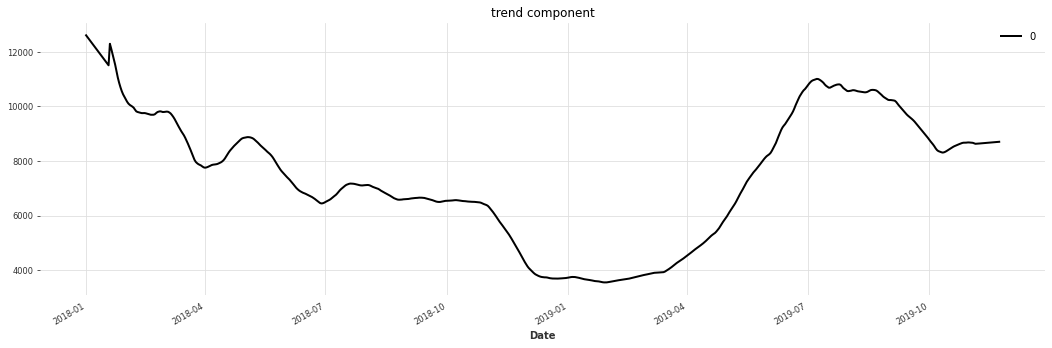

In [28]:
# ETS analysis: try to discern trend and seasonal components
ts_trend, ts_seas = extract_trend_and_seasonality(ts=series, freq=mseas)

plt.figure(100, figsize=(18, 5))
ts_trend.plot()
plt.title("trend component");

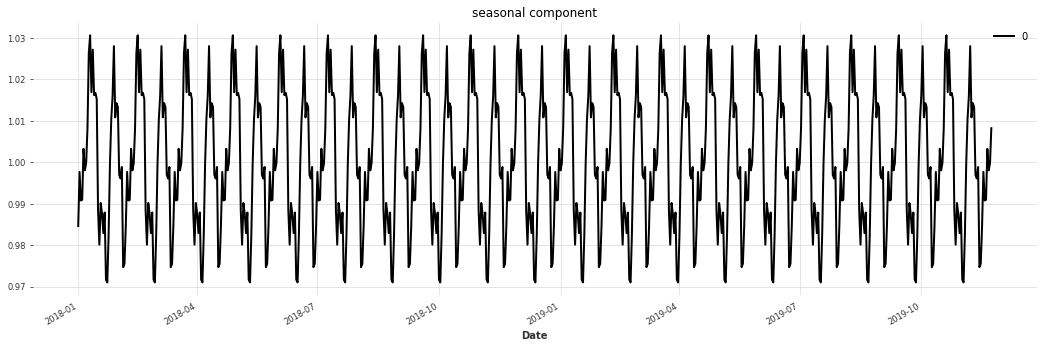

In [29]:
plt.figure(100, figsize=(18, 5))
ts_seas.plot()
plt.title("seasonal component");

# Naive Baseline Forecast

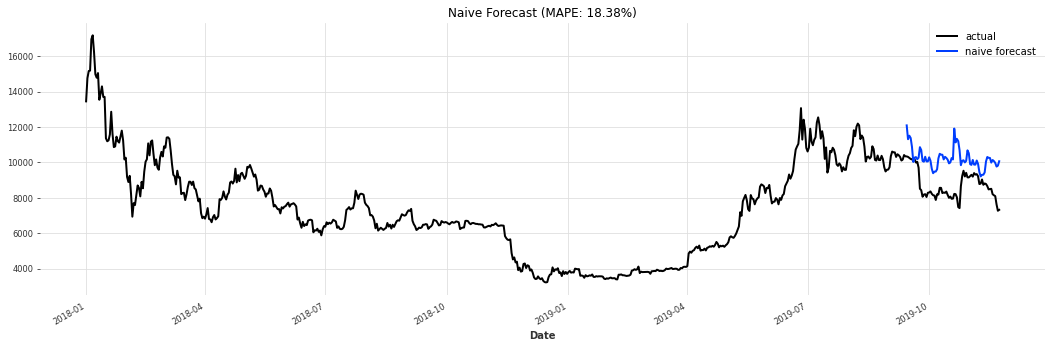

In [30]:
# naive seasonal forecast
modelNs = NaiveSeasonal(K=36)
modelNs.fit(train)
ts_predNs = modelNs.predict(len(test))

# naive drift (trend) forecast
modelNd = NaiveDrift()
modelNd.fit(train)
ts_predNd = modelNd.predict(len(test))

ts_predN = ts_predNd + ts_predNs - ts_train.last_value()

plt.figure(100, figsize=(18, 5))
series.plot(label="actual")
ts_predN.plot(label="naive forecast")
plt.title("Naive Forecast (MAPE: {:.2f}%)".format(mape(test, ts_predN)))
plt.legend()

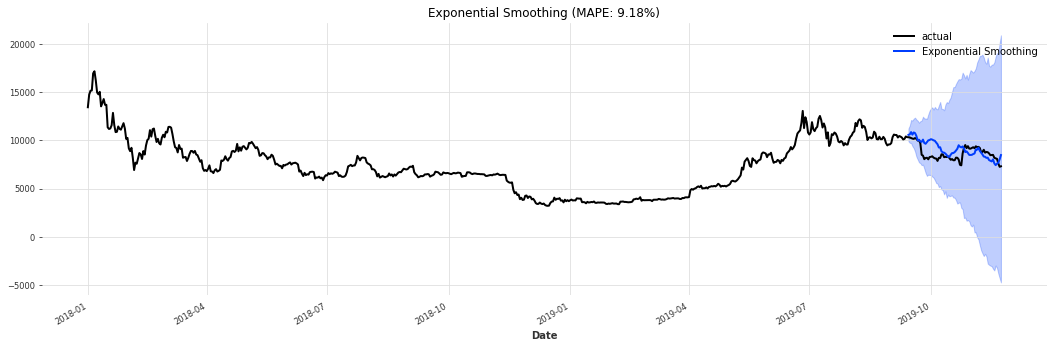

In [31]:
modelX = ExponentialSmoothing(
                seasonal_periods=36, 
                seasonal=ModelMode.MULTIPLICATIVE)
modelX.fit(train)
ts_predX = modelX.predict(  n=len(test), 
                            num_samples=100)

plt.figure(100, figsize=(18, 5))
series.plot(label="actual")
ts_predX.plot(label="Exponential Smoothing")
plt.title("Exponential Smoothing (MAPE: {:.2f}%)".format(mape(test, ts_predX)))
plt.legend();

# TFT model

In [32]:
# create time series object for target variable
ts_P = TimeSeries.from_series(df["Price"]) 

# check attributes of the time series
print("components:", ts_P.components)
print("duration:",ts_P.duration)
print("frequency:",ts_P.freq)
print("frequency:",ts_P.freq_str)
print("has date time index? (or else, it must have an integer index):",ts_P.has_datetime_index)
print("deterministic:",ts_P.is_deterministic)
print("univariate:",ts_P.is_univariate)

components: Index(['Price'], dtype='object', name='component')
duration: 691 days 00:00:00
frequency: <Day>
frequency: D
has date time index? (or else, it must have an integer index): True
deterministic: True
univariate: True


In [33]:
model = TFTModel(   input_chunk_length=30,
                    output_chunk_length=1,
                    hidden_size=64,
                    lstm_layers=1,  #LSTMLAYERS,
                    num_attention_heads=1,
                    dropout=0.1,
                    batch_size=64,
                    n_epochs=100,
                    #likelihood=QuantileRegression(quantiles=QUANTILES), 
                    random_state=42, 
                    force_reset=True,
                 torch_device_str ="cuda")

In [34]:
# training
model.fit(  ts_ttrain, 
            future_covariates=cov_t, 
            verbose=True)

Training: 0it [00:00, ?it/s]

In [35]:
# testing: generate predictions
ts_tpred = model.predict(   n=len(ts_ttest), 
                            num_samples=100,   
                            n_jobs=3)

Predicting: 10it [00:00, ?it/s]

In [36]:
print("Do the predictions constitute a probabilistic time series?", ts_tpred.is_probabilistic)

Do the predictions constitute a probabilistic time series? True


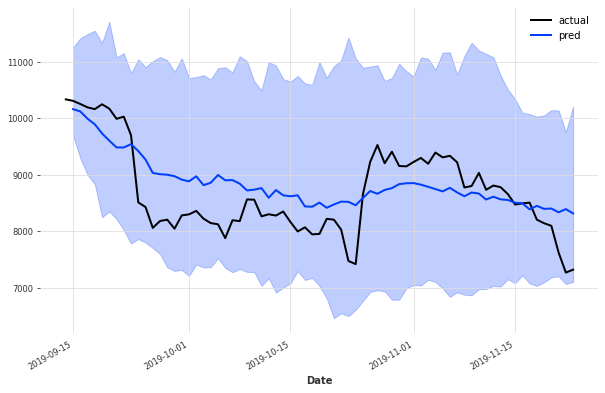

In [37]:
# testing: call helper function: plot predictions
ts_pred = scaler.inverse_transform(ts_tpred)

plt.figure(figsize=(10, 6))
    
test.plot(label="actual")  
ts_pred.plot(label="pred")

In [40]:
mape_error = mape(test,ts_pred)
rmse_error = rmse(test,ts_pred)
#mae_error = mae(test,ts_pred)
print("MAPE:",mape_error)
print("rmse:",rmse_error)
#print("mae:", mae_error)

MAPE: 5.770434745363898
rmse: 564.0012545722313


# Temporal Convolutional Network

In [87]:
from darts.models import TCNModel
#30 day window
EPOCH = 100    
FC_N = 30               # forecast periods
FC_STRIDE = 10
DROP = 0.1
LEARN = 0.001

model_TCN = TCNModel(
        input_chunk_length=30,
        output_chunk_length=1, 
        n_epochs=EPOCH,
        dropout=DROP,
        dilation_base=2,
        weight_norm=True,
        batch_size=16,
        kernel_size=5,
        num_filters=3,
        optimizer_kwargs={'lr': LEARN},
        log_tensorboard=True,
        force_reset=True,
        random_state=42)

In [88]:
# training: load a saved model or (re)train
model_TCN.fit(  series=ts_ttrain, 
            past_covariates=cov_t,
                val_series=ts_ttest,  
          val_past_covariates=cov_t,
                verbose=True)

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [89]:
# testing: generate predictions
TCN_ts_tpred = model_TCN.predict(   n=len(ts_ttest),  
                            past_covariates=cov_t, 
                            verbose=True)

Predicting: 37it [00:00, ?it/s]

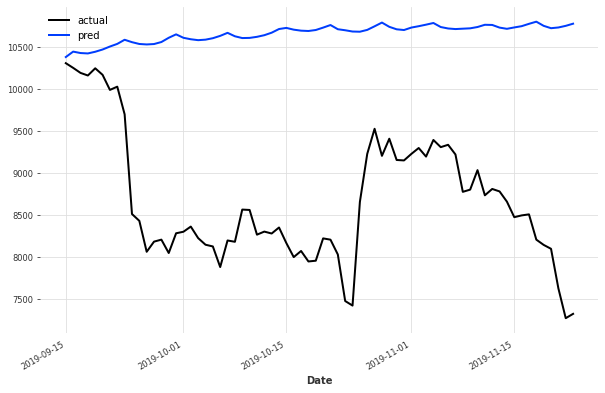

In [90]:
pred = scaler.inverse_transform(TCN_ts_tpred)
actual = scaler.inverse_transform(ts_ttest)

plt.figure(figsize=(10, 6))
actual.plot(label="actual")
pred.plot(label="pred")

In [91]:
mape_error = mape(actual,pred)
rmse_error = rmse(actual,pred)
mae_error = mae(actual,pred)
print("MAPE:",mape_error)
print("rmse:",rmse_error)
print("mae:", mae_error)

MAPE: 23.90519827604294
rmse: 2148.4233
mae: 1991.434


# NBEATS MODEL

In [92]:
#NBEATSModel - 7 day window
NBEATS_model = NBEATSModel(    input_chunk_length=7,
                        output_chunk_length=1, 
                        num_stacks=32,
                        layer_widths=16,
                        batch_size=64,
                        n_epochs=100,
                        nr_epochs_val_period=1,  
                        log_tensorboard=True,
                        generic_architecture=True, 
                        random_state=42,
                        force_reset=True,
                        save_checkpoints=True,
                        torch_device_str="cuda"
                    )

In [93]:
# training: load a saved model or (re)train
NBEATS_model.fit(  series=ts_ttrain, 
            past_covariates=cov_t,
                val_series=ts_ttest,  
          val_past_covariates=cov_t,
                verbose=True)

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [94]:
# testing: generate predictions
ts_tpred = NBEATS_model.predict(   n=len(ts_ttest),  
                            past_covariates=cov_t, 
                            verbose=True)

Predicting: 10it [00:00, ?it/s]

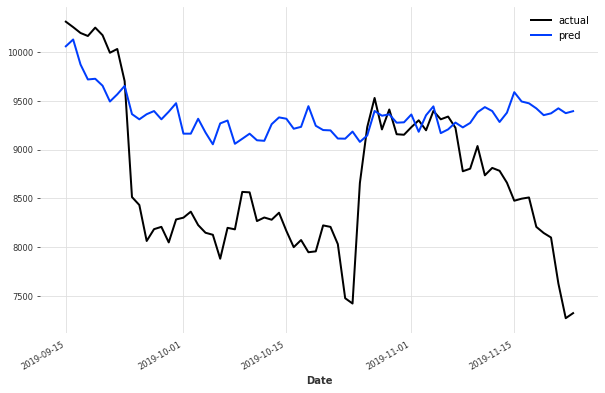

In [95]:
pred = scaler.inverse_transform(ts_tpred)
actual = scaler.inverse_transform(ts_ttest)

plt.figure(figsize=(10, 6))
actual.plot(label="actual")
pred.plot(label="pred")

In [96]:
mape_error = mape(actual,pred)
rmse_error = rmse(actual,pred)
mae_error = mae(actual,pred)
print("MAPE:",mape_error)
print("rmse:",rmse_error)
print("mae:", mae_error)

MAPE: 9.566692262887955
rmse: 939.4502
mae: 785.2134


In [97]:
#NBEATSModel - 30 day window
NBEATS_model_30 = NBEATSModel(    input_chunk_length=30,
                        output_chunk_length=1, 
                        num_stacks=32,
                        layer_widths=16,
                        batch_size=64,
                        n_epochs=100,
                        nr_epochs_val_period=1,  
                        log_tensorboard=True,
                        generic_architecture=True, 
                        random_state=42,
                        force_reset=True,
                        save_checkpoints=True,
                        torch_device_str="cuda"
                    )

In [98]:
# training: load a saved model or (re)train
NBEATS_model_30.fit(  series=ts_ttrain, 
            past_covariates=cov_t,
                val_series=ts_ttest,  
          val_past_covariates=cov_t,
                verbose=True)

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [101]:
# testing: generate predictions
ts_tpred_30 = NBEATS_model_30.predict(   n=len(ts_ttest),  
                            past_covariates=cov_t, 
                            verbose=True)

Predicting: 10it [00:00, ?it/s]

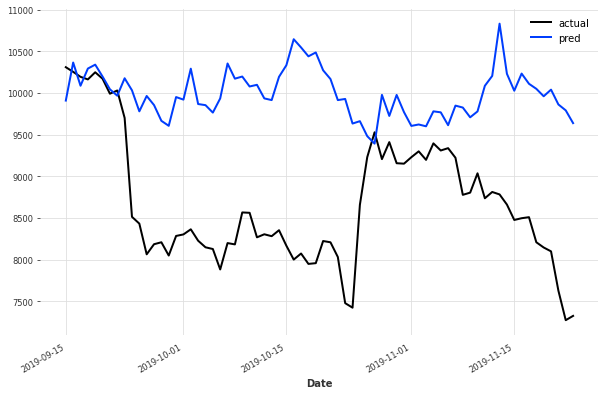

In [102]:
pred = scaler.inverse_transform(ts_tpred_30)
actual = scaler.inverse_transform(ts_ttest)

plt.figure(figsize=(10, 6))
actual.plot(label="actual")
pred.plot(label="pred")

In [103]:
mape_error = mape(actual,pred)
rmse_error = rmse(actual,pred)
mae_error = mae(actual,pred)
print("MAPE:",mape_error)
print("rmse:",rmse_error)
print("mae:", mae_error)

MAPE: 16.254226863384247
rmse: 1549.1877
mae: 1338.4313


# Grid Search CV

In [43]:
parameters = {
    "input_chunk_length" : [7,30,60],
    "output_chunk_length" : [1,7], 
    "hidden_size" : [4,8],
    "lstm_layers" : [1,2],
    "torch_device_str" : ["cuda"]
    
}

best_model = model.gridsearch(parameters=parameters,series=ts_ttrain,forecast_horizon=30,start=0.9,stride=20
                              ,last_points_only=False,future_covariates=cov_t,metric=mape,reduction=np.mean)

best_model.fit(train,epochs=50,verbose=True)
best_model.forecast = best_model.predict(len(test))

Training: 0it [00:00, ?it/s]

Predicting: 18it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 18it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 18it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 18it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 18it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 18it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 18it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 18it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 18it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 18it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 18it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 18it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 18it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 18it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 18it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 18it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 17it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 18it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 17it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 2it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 5it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 15it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 11it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 1it [00:00, ?it/s]

KeyboardInterrupt: 

In [ ]:
parameters = {
    "input_chunk_length" : [30,32,64,72,128,256],
    "output_chunk_length" : [1,2,4,6,8,16], 
    "dilation_base" : [0,1,2,3,4],
    "dropout" : [0.0,0.1,0.2],
    "torch_device_str" : ["cuda"],
    "weight_norm" : [True],
    "batch_size" : [16,32,64],
    "kernel_size" : [2,3,4,5,6,7],
    "num_filters" : [2,3,4,5,6]
    
}

best_model_TCN = model_TCN.gridsearch(parameters=parameters,series=ts_ttrain,forecast_horizon=30,start=0.7,stride=20
                              ,last_points_only=False,past_covariates=cov_t,metric=mape,reduction=np.mean)

best_model_TCN.fit(train,epochs=100,verbose=True)
best_model_TCN.forecast = best_model_TCN.predict(len(test))